In this notebook, we compute a distance matrix $M$ based on the wasserstein metric via scipy
The matrix contains the pairwise distances between $100$ probability Gaussian distributions
whose mean value $\mu$ labels the clusters they belong to.

In [1]:
import scipy as sp
import statsmodels.api as sm
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd
import scanpy as sc
from sklearn.metrics import mutual_info_score
from matplotlib import pyplot as plt
from scipy.stats import entropy
from scipy.stats import wasserstein_distance
from scipy.spatial.distance import jensenshannon
from scipy.special import kl_div
from persim import plot_diagrams 
from ripser import ripser, lower_star_img
from sklearn.cluster import KMeans
from numpy import histogram
import scipy.stats

Set of 100 Gaussian PDFs clustered in groups of 20 according to their mean value $\mu$

In [6]:
rng = np.random.default_rng()
scipy.stats.norm.rvs
#initialise synthetic dataframe
n_pdfs=100
x_size=1000000

X=np.zeros([n_pdfs,x_size]) #Whole sample dataset
var=3*rng.random(size=n_pdfs)
mu=np.zeros(n_pdfs)
j=1
for i in range(0,n_pdfs):
    mu[i]=2*j
    if (i+1)%20==0:
        j=j+1
        
for i in range(0,n_pdfs):
    aux = rng.normal(loc=mu[i], scale = var[i], size=x_size)
    X[i,:] = aux

Build Wasserstein distance (W-distance) matrix

In [7]:
#Build distance matrix
batch_size_features= X.shape[0]
Mw_matrix = np.zeros((batch_size_features,batch_size_features)) #w distance matrix

for col_i in range(0,batch_size_features):
    for col_j in range(col_i,batch_size_features):
        Mw_matrix[col_i,col_j] = wasserstein_distance(X[col_i,:]
                                                      ,X[col_j,:])     
Mw_matrix= Mw_matrix+Mw_matrix.T-np.diag(np.diag(Mw_matrix))

Plot W-distance matrix

Text(0.5, 1.0, 'Wasserstein distances matrix')

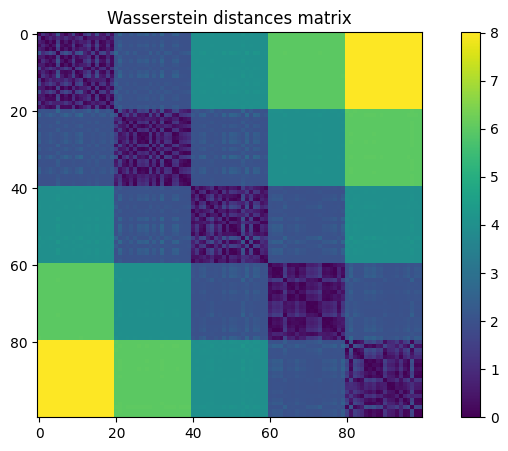

In [8]:
#dgm = lower_star_img(Mw_matrix)
plt.figure(figsize=(10, 5))
#plt.subplot(121)
plt.imshow(Mw_matrix)
plt.colorbar()
plt.title("Wasserstein distances matrix")

We will now cluster the distributions using [hdbscan](https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html) a clustering algorithm. This algorithm requires only the distance matrix to perform clustering. Then, we comparte the pre-known labels with the labels produced via the clustering algorithm using the function "adjusted_rand_score". 

In [10]:
import hdbscan
clusterer = hdbscan.HDBSCAN(algorithm='best',metric='precomputed',min_cluster_size=5)
clusterer.fit(Mw_matrix)
#evaluating clustering
from sklearn.metrics import adjusted_rand_score
rand_index = adjusted_rand_score(labels_true = mu, labels_pred = clusterer.labels_)
print('The Score index is', round(rand_index, 2))

The Score index is 0.93


We now perform the clustering via multidimensional scaling (MDS) and the Kmeans algorithm. First, MDS translates the information about the pairwise 'distances' among the elements on the distance matrix which can permit us to perform the Kmeans clustering. To find the best dimension where the matrix $M$ can be translated to, we perform the stress index for dimensions 1 to 15 and use a simple elbow rule to detect which dimension is the best. The result gives dimension 3 as the best result.

Text(0.5, 0, 'Dimension')

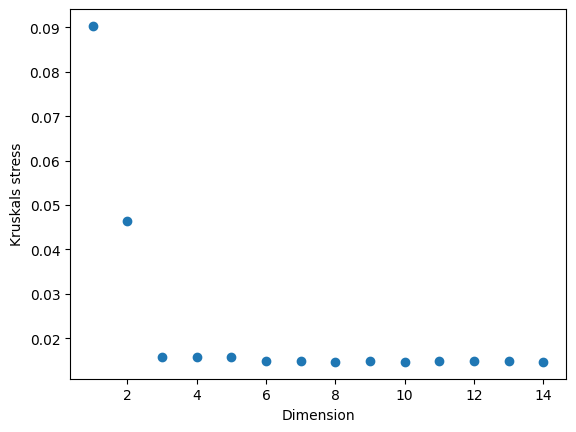

In [11]:
from sklearn.manifold import MDS
from sklearn.metrics import euclidean_distances
import seaborn as sns
s,si=[],[]
stress1,i=1,1
while i<15:
    mds = MDS(n_components=i,dissimilarity='precomputed', random_state=0, normalized_stress='auto')
    # Get the embeddings
    X_transform = mds.fit_transform(Mw_matrix)
    ## Kruskal's stress (or stress formula 1)
    DE = euclidean_distances(X_transform)
    stress = 0.5 * np.sum((DE - Mw_matrix)**2)
    stress1=np.sqrt(stress / (0.5 * np.sum(Mw_matrix**2)))
    s.append(stress1)
    si.append(i)
    i=i+1
plt.scatter(si,s)
plt.ylabel('Kruskals stress')
plt.xlabel('Dimension')

Perform MDS using 3 components

In [18]:
mds = MDS(n_components=3,dissimilarity='precomputed',
          random_state=0, normalized_stress='auto')
# Get the embeddings
X_transform = mds.fit_transform(Mw_matrix)

Similarly to the MDS procedure, for Kmeans algorithm we perform the elbow rule to detect the best number of clusters that we should use in our algorithm. The result, as expected, is 5.

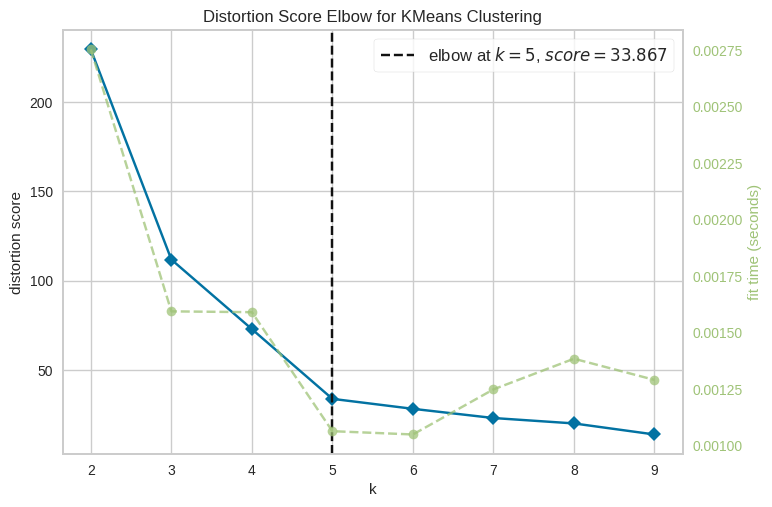

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [19]:
from sklearn import datasets
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
km = KMeans(random_state=0,n_init='auto')
visualizer = KElbowVisualizer(km, k=(2,10))

visualizer.fit(X_transform)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

Ploting the data clusters

<Axes: >

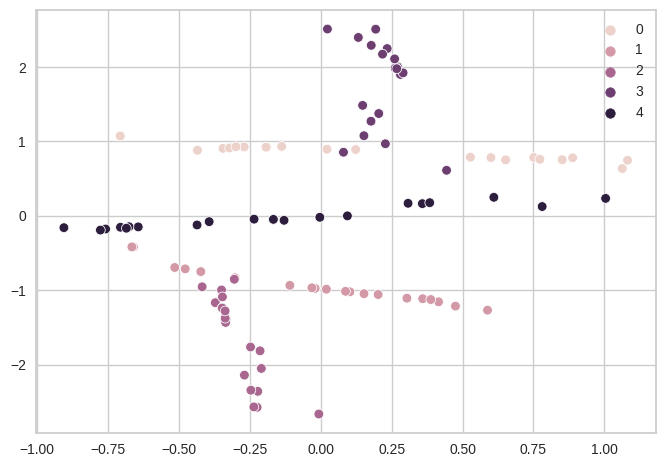

In [20]:
import re, seaborn as sns
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

kmeans_model = KMeans(n_clusters = 5,n_init='auto')
kmeans_model.fit(X_transform)
sns.scatterplot(x=X_transform[:,0],y=X_transform[:,1],hue=kmeans_model.labels_)

Perform a comparison between the pre-known labels and the labels produced via the kmeans algorithm.

In [21]:
from sklearn.metrics import adjusted_rand_score
rand_index = adjusted_rand_score(labels_true = mu, labels_pred = kmeans_model.labels_)
print('The Score index is', round(rand_index, 2))

The Score index is 1.0


References

Earth's moving distance in Julia https://simonensemble.github.io/pluto_nbs/emd.jl.html

Earth's moving distance in Python https://pythonot.github.io/
